# Проведение АА-тестов

По данным с '2022-01-24' по '2023-01-30', нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом. Сделать выводы об одинаковости выборок, корректоности работы системы сплитования

## 1. Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import seaborn as sns
import hashlib
import pandahouse as ph
import random
from scipy.stats import norm, ttest_ind

### 2. Выгрузка данных по условию

In [2]:
# функция для выполнения запосов
def select(q):
    return ph.read_clickhouse(q, connection=connection)

In [3]:
# устанавливаем параметры
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230220'
}

In [4]:
# Выгрузка данных по условию: '2022-01-24' по '2023-01-30' и 2 и 3 экспериментальной группы
query = '''SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-24' and '2023-01-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
'''

In [5]:
df_group = select(query)  # сохраняем данныe по условию: '2022-01-24' по '2023-01-30' и 2 и 3 экспериментальной группы

In [6]:
df_group

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


### 3. Размер выборки

In [7]:
# Калькулятор размера выборки
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

In [8]:
# Для просмотров выгрузим статистику
query = """
select views, count() as users
from (select  
    exp_group,
    user_id,
    sum(action = 'view') as views
from {db}.feed_actions 
where toDate(time) between '2023-01-24' and '2023-01-30'
    and exp_group in (1,2,3,4,5)
group by exp_group, user_id
)
group by views
order by views
"""


views_distribution = select(query)

In [9]:
views_distribution['users'].sum()  # всего юзеров

34101

In [10]:
views_distribution['p'] = views_distribution['users']/views_distribution['users'].sum()  # распределение вероятностей появления каждого из значений "users"

In [11]:
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
15,16,427,0.012522
14,15,420,0.012316
16,17,420,0.012316
13,14,394,0.011554
30,31,394,0.011554
...,...,...,...
287,289,1,0.000029
288,290,1,0.000029
291,293,1,0.000029
292,294,1,0.000029


In [12]:
# построение произвольного распределения, определяемого списком "views" и соответствующих вероятностей.
views_distr = st.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

In [13]:
sample = views_distr.rvs(size=300)

print('Первые 10 значений выборки:\n', sample[:10])
print('Выборочное среденее: %.3f' % sample.mean())
print('Частота значений по выборке:', 
      (sample == 1).mean(), (sample == 2).mean(), (sample == 3).mean())

Первые 10 значений выборки:
 [116  53  34  69  96  23  85  93  18  14]
Выборочное среденее: 76.067
Частота значений по выборке: 0.0 0.0033333333333333335 0.0


In [14]:
# Для CTR выгрузим статистику за неделю, таким образом мы учтем сезонность поведения пользователей
query = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from {db}.feed_actions 
where dt between '2023-01-24' and '2023-01-30'
    and exp_group in (1,2,3,4,5)
group by dt, exp_group, user_id
)
group by ctr
"""


ctr_distribution = select(query)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()

In [15]:
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
17,0.20,4125,0.060269
6,0.18,3429,0.050100
31,0.16,3405,0.049749
48,0.25,3246,0.047426
27,0.17,3222,0.047076
...,...,...,...
19,0.80,1,0.000015
37,0.88,1,0.000015
9,0.78,1,0.000015
26,0.68,1,0.000015


In [16]:
# построение произвольного распределения, определяемого списком "CTR" и соответствующих вероятностей
probabilities = ctr_distribution['p']
values = ctr_distribution['ctr']
distrib = st.rv_discrete(values=(range(len(probabilities)), probabilities))

def get_ctrs(x, y):
    idx = distrib.rvs(size=x*y)
    result = values[idx]
    return np.array(result).reshape(x,y)

### 4. Синтетический А-А тест

In [17]:
# Найдем среднеквадратическое отклонение за выбранную неделю
query = """
select 
   stddevPop(ctr) as ctr_std
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from {db}.feed_actions 
where dt between '2023-01-24' and '2023-01-30'
    and exp_group in (1,2,3,4,5)
group by dt, exp_group, user_id
)

"""

std = select(query).values[0][0]
std

0.0960017672016051

#### Найдем размер выборки используя формулу

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Здесь $\varepsilon$ - размер эффекта, $\alpha$ - вероятность ошибки первого рода, $\beta$ - вероятность ошибки 2 рода

In [18]:
# Расчитаем размер выборки, принимая, что std одинаковые и расчитано выше, хотим заметить изменеие в 5%, т.е. если средний ctr на уровне 0.21, то хотим увидеть 0.22
compute_sample_size_abs(0.01, std, std)

1447

In [19]:
# из распеределения просмотров генерируем 2000 выборок по 1447 наблюдений
group_A_views = views_distr.rvs(size = (2000, 1447))
group_B_views = views_distr.rvs(size = (2000, 1447))
# сгенерируем распределение ctr
group_A_ctr = get_ctrs(2000, 1447) * 1.05
group_B_ctr = get_ctrs(2000,1447)
# сгенерируем клики из биномиального распределения, зная распределение просмотров и ctr
clicks_A = st.binom.rvs(group_A_views, group_A_ctr)
clicks_B = st.binom.rvs(group_B_views, group_B_ctr)

In [20]:
def t_test(a, b):
    """
    Считает p-value для t-теста с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value t-теста для всего списка экспериментов
    """
    result = list(map(lambda x: st.ttest_ind(
        x[0], x[1]).pvalue, zip(a, b)))
    return np.array(result)

In [21]:
# таким образом мы посчитаем в каком количестве случаев мы увидим разницу в 5% случаев
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.688

In [22]:
#  променяем количество наблюдений, хотим достигнуть 80 % 
# из распеределения просмотров генерируем 2000 выборок по 2000 наблюдений
group_A_views = views_distr.rvs(size = (2000, 2000))
group_B_views = views_distr.rvs(size = (2000, 2000))
# сгенерируем распределение ctr
group_A_ctr = get_ctrs(2000, 2000) * 1.05  # увеление среднего ctr на 5 %
group_B_ctr = get_ctrs(2000, 2000)
# сгенерируем клики из биномиального распределения, зная распределение просмотров и ctr
clicks_A = st.binom.rvs(group_A_views, group_A_ctr)
clicks_B = st.binom.rvs(group_B_views, group_B_ctr)

In [23]:
# таким образом мы посчитаем в каком количестве случаев мы увидим разницу в 5% случаев
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.8265

Вывод: Таким образом образом пришли к тому, что для того чтобы увидеть изменеия в 5 % (увелечение среднего CTR на 0.01) и при длительности эксперимента в 1 неделю, необходимо взять минимум 2000 наблюдений

### 5. Проверка гипотез

Нулевая гипотеза(Н0) – средние двух выборок равны (средние пользовательские CTR равны), альтернативная гипотеза(Н1) – средние пользовательские CTR 2 и 3 экспериментальной группы различаются.

In [24]:
alpha = .05 # критический уровень статистической значимости

In [25]:
# Создадим вспомогательную функцию
def sim (df1, df2, n_users, n_tests):
    p_value = []
    for i in range(n_tests):
        sample_1 = df1.sample(n_users, replace=False)
        sample_2 = df2.sample(n_users, replace=False)
        t_test = st.ttest_ind(sample_1, sample_2, equal_var=False)
        p_value.append(t_test[1])
    return p_value

In [26]:
p_value = sim(df_group[df_group['exp_group'] == 2].ctr, df_group[df_group['exp_group'] == 3].ctr, 500, 10000)

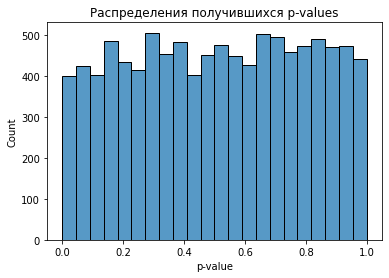

In [27]:
sns.histplot(p_value)
plt.title('Распределения получившихся p-values')
plt.xlabel('p-value')
plt.show()

In [28]:
print('Среднее значение p-value:', sum(p_value) / len(p_value))

Среднее значение p-value: 0.5095057567528715


In [29]:
print('Процент p-values меньше либо равен 0.05:', len([item for item in p_value if item <= 0.05]) / len(p_value) * 100, '%')

Процент p-values меньше либо равен 0.05: 4.33 %


### Вывод

Рассматривая распределение получившихся p-values и учитывая, что процент тестов, которые показывают изменения, т.е. отвергается нулевая гипотеза о равенстве,  меньше  чем в 5% случаях от всего количество проведенных тестов.
Согласно проведенному анализу, можно прийти к выводу, что выборки одинаковые, т.е. наша система сплитования корректно работает